In [1]:
# Packages 
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from scipy.signal.windows import dpss
from nitime.algorithms.spectral import multi_taper_psd
from mne.time_frequency import psd_array_multitaper
from numpy.lib.stride_tricks import sliding_window_view

from specparam import SpectralModel

---
##### **Some plotting functions**

In [2]:
def plot_trace(trace, time, size=(5, 2), xlim=(0, 0.05), title='Signal', trace_color='tab:blue', linewidth=2):
    
    plt.figure(figsize=size)
    plt.plot(time, trace, color=trace_color, linewidth=linewidth, label='Signal')
    
    t_arr = np.asarray(time)
    y_arr = np.asarray(trace)
    mask = (t_arr >= xlim[0]) & (t_arr <= xlim[1])
    
    if np.any(mask):
        visible_y = y_arr[mask]
        y_min = visible_y.min()
        y_max = visible_y.max()
        
        y_range = y_max - y_min
        if y_range == 0: y_range = 1.0  # Prevent crash if flat line
        margin = y_range * 0.1
        plt.ylim(y_min - margin, y_max + margin)
    
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.xlim(xlim)
    plt.grid(True, which='both', linestyle='--', alpha=0.7)
    plt.axhline(0, color='black', linewidth=0.8) 
    plt.legend()
    plt.show()
    
    
def plot_psd_log(psd, freqs, size = (5, 4), xlim = None, title = 'PSD', color = 'black', linewidth = 1.5):
    
    plt.figure(figsize = size)
    plt.loglog(freqs, psd, color = color, linewidth = linewidth)
    
    if xlim is not None:
        plt.xlim(xlim)
        f_arr = np.asarray(freqs)
        p_arr = np.asarray(psd)
        mask = (f_arr >= xlim[0]) & (f_arr <= xlim[1]) & (f_arr > 0)

        if np.any(mask):
            visible_power = p_arr[mask]
            p_min = visible_power.min()
            p_max = visible_power.max()
            plt.ylim(p_min * 0.8, p_max * 1.5)
    
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power ($AU^2/Hz$)")
    
    plt.grid(True, which = 'both', linestyle = '--', alpha = 0.6)
    plt.show()

---
##### **Different types of kernels**
- Alpha functions, square pulses and dual exponentials.

In [3]:
def alpha_function(t_sec, fs, tau_s, max_amplitude, effective_duration = 0.1):
    
    N = int(fs * t_sec)
    time = np.arange(N) / fs 
    kernel = time * np.exp(-time / tau_s)
    kernel[time > effective_duration] = 0
    
    if np.max(kernel) > 0:
        kernel = kernel / np.max(kernel) * max_amplitude
        
    return kernel, time 


def triple_square_kernel(t_sec, fs, t1_s, t2_s, t3_s, amplitude1 = 1.0, amplitude2 = 1.0, amplitude3 = 1.0):
 
    # Generates a square pulse kernel with three possible amplitude levels 

    N = int(fs * t_sec)
    time = np.arange(N) / fs
    kernel = np.zeros_like(time)
    
    kernel[(time >= 0) & (time < t1_s)] = amplitude1
    kernel[(time >= t1_s) & (time < t2_s)] = amplitude2
    kernel[(time >= t2_s) & (time < t3_s)] = amplitude3
    kernel[time >= t3_s] = 0
    
    return kernel, time

    
def dual_exponential(t_sec, fs, tau_rise_s, tau_decay_s, max_amplitude, effective_duration = 0.1):
    
    if tau_rise_s >= tau_decay_s:
        print(f'tau_rise_s ({tau_rise_s}) must be greater than tau_decay_s ({tau_decay_s}).')
        return 0
    
    N = int(fs * t_sec)
    time = np.arange(N) / fs
    kernel = np.exp(-time / tau_decay_s) - np.exp(-time / tau_rise_s)
    kernel[time > effective_duration] = 0
    
    if np.max(kernel) > 0:
        kernel = kernel / np.max(kernel) * max_amplitude
    
    return kernel, time

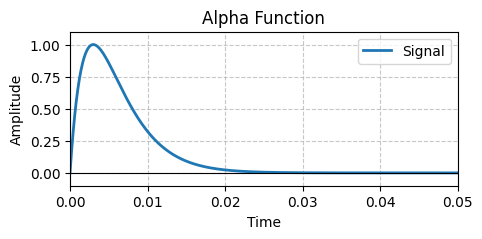

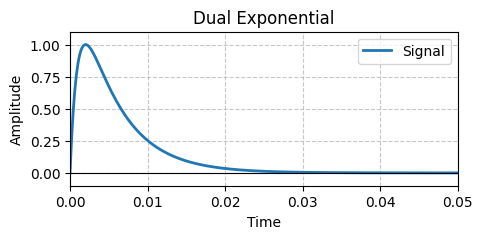

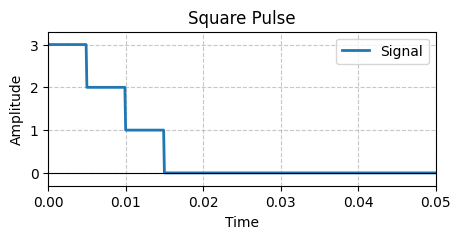

In [4]:
kernel_alpha, time_alpha = alpha_function(t_sec = 0.2,
                                          fs = 10000,
                                          tau_s = 3 / 1000, 
                                          max_amplitude = 1)

kernel_dexp, time_dexp = dual_exponential(t_sec = 0.2, 
                                          fs = 10000, 
                                          tau_rise_s = 1 / 1000,
                                          tau_decay_s = 5 / 1000, 
                                          max_amplitude = 1)

kernel_sq, time_sq = triple_square_kernel(t_sec = 0.2,
                                          fs = 10000, 
                                          t1_s = 5 /  1000, 
                                          t2_s = 10 / 1000,
                                          t3_s = 15 / 1000,
                                          amplitude1 = 3.0, 
                                          amplitude2 = 2.0, 
                                          amplitude3 = 1.0)

plot_trace(kernel_alpha, time_alpha, title = 'Alpha Function')
plot_trace(kernel_dexp, time_dexp, title = 'Dual Exponential')
plot_trace(kernel_sq, time_sq, title = 'Square Pulse')

---
##### **Simulating LFPs as a superposition of synaptic events**

In [5]:
def simulate_fpp(kernel, fs, t_sec, num_neurons, rate):
    
    N = int(fs * t_sec)
    time = np.arange(N) / fs
    n_bins = len(time)
    dt = 1 / fs 
    
    # Spike train
    prob_spike = rate * dt 
    spikes_pop = np.random.binomial(n = num_neurons, p = prob_spike, size = n_bins) 
    
    # Match number of points between the kernel and the signal
    if len(kernel) != N:
        print(f'Kernel must have the same number of points of the signal.')
        return 0
    
    F_spike = np.fft.fft(spikes_pop)
    F_kernel = np.fft.fft(kernel)
    signal = np.fft.ifft(F_spike * F_kernel).real
    signal = signal - np.mean(signal)
    
    event_rate = np.sum(spikes_pop) / t_sec
    
    return signal, time, event_rate

In [6]:
kernel_dexp, time_dexp = dual_exponential(t_sec = 10, 
                                          fs = 10000, 
                                          tau_rise_s = 1 / 1000,
                                          tau_decay_s = 2 / 1000, 
                                          max_amplitude = 1)

signal, time_signal, event_rate_s = simulate_fpp(kernel = kernel_dexp,
                                                 fs = 10000,
                                                 t_sec = 10, 
                                                 num_neurons = 5000, 
                                                 rate = 40)

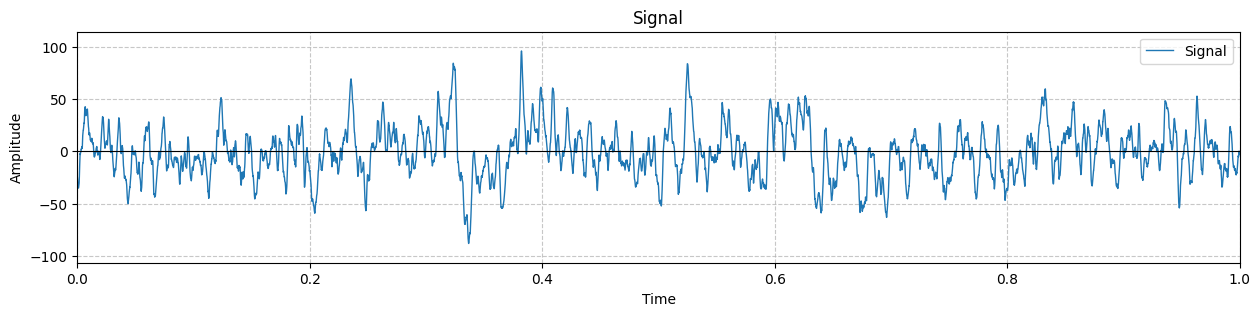

In [7]:
plot_trace(signal, time_signal, size = (15, 3), xlim = (0, 1), linewidth = 1)

In [8]:
def simulate_fpp_balance(kernel_ex, kernel_in, fs, t_sec, n_ex, n_in, rate_ex, rate_in, w_ex = -1, w_in = 1):
    
    N = int(fs * t_sec)
    time = np.arange(N) / fs
    n_bins = len(time)
    dt = 1 / fs 
    
    # Excitatory and inhibitory spike trains 
    prob_spike_ex = rate_ex * dt 
    spikes_pop_ex = np.random.binomial(n = n_ex, p = prob_spike_ex, size = n_bins)
    prob_spike_in = rate_in * dt 
    spikes_pop_in = np.random.binomial(n = n_in, p = prob_spike_in, size = n_bins) 
    
    # Match number of points between the kernel and the signal
    if len(kernel_ex) != N or len(kernel_in) != N:
        print('Kernels must have the same number of points of the signal.')
        return 0
    
    # FFT
    F_spike_ex = np.fft.fft(spikes_pop_ex)
    F_spike_in = np.fft.fft(spikes_pop_in)
    F_kernel_ex = np.fft.fft(kernel_ex)
    F_kernel_in = np.fft.fft(kernel_in)
    
    # Excitatory and inhibitory signals 
    signal_ex = np.fft.ifft(F_spike_ex * F_kernel_ex).real
    signal_in = np.fft.ifft(F_spike_in * F_kernel_in).real
    signal_ex = signal_ex - np.mean(signal_ex)
    signal_in = signal_in - np.mean(signal_in)
    
    # Total signal
    total_signal = (signal_ex * w_ex) + (signal_in * w_in)
    
    return total_signal, (signal_ex * w_ex), (signal_in * w_in), time

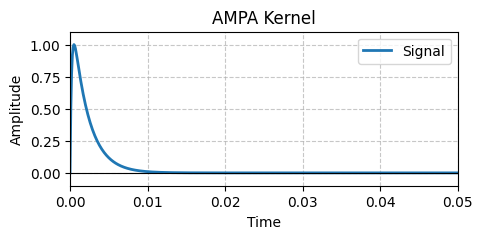

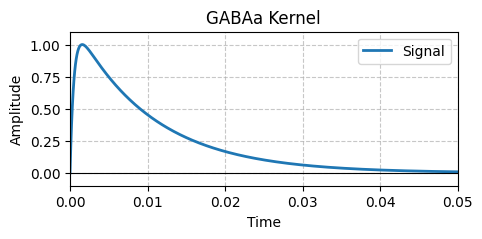

In [9]:
kernel_ampa, time_ampa = dual_exponential(t_sec = 1, 
                                          fs = 10000, 
                                          tau_rise_s = 0.2 / 1000,
                                          tau_decay_s = 2 / 1000, 
                                          max_amplitude = 1)

kernel_gaba, time_gaba = dual_exponential(t_sec = 1, 
                                          fs = 10000, 
                                          tau_rise_s = 0.5 / 1000,
                                          tau_decay_s = 10 / 1000, 
                                          max_amplitude = 1)

plot_trace(kernel_ampa, time_ampa, title = 'AMPA Kernel')
plot_trace(kernel_gaba, time_gaba, title = 'GABAa Kernel')

In [10]:
lfp_total, lfp_ex, lfp_in, time_lfp = simulate_fpp_balance(kernel_ex = kernel_ampa, 
                                                           kernel_in = kernel_gaba, 
                                                           fs = 10000, 
                                                           t_sec = 1, 
                                                           n_ex = 5000, 
                                                           n_in = 5000, 
                                                           rate_ex = 50, 
                                                           rate_in = 50)

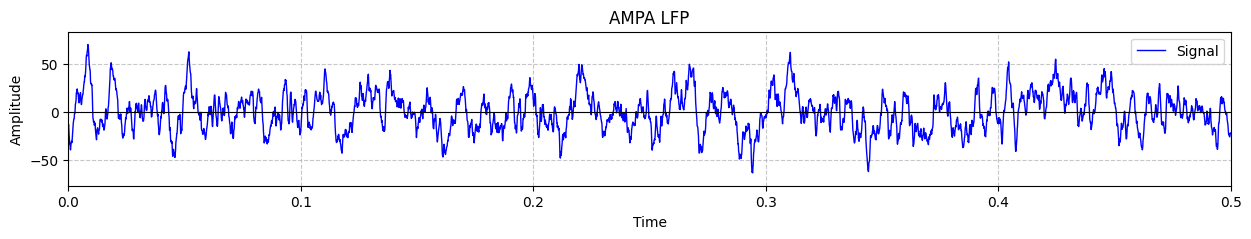

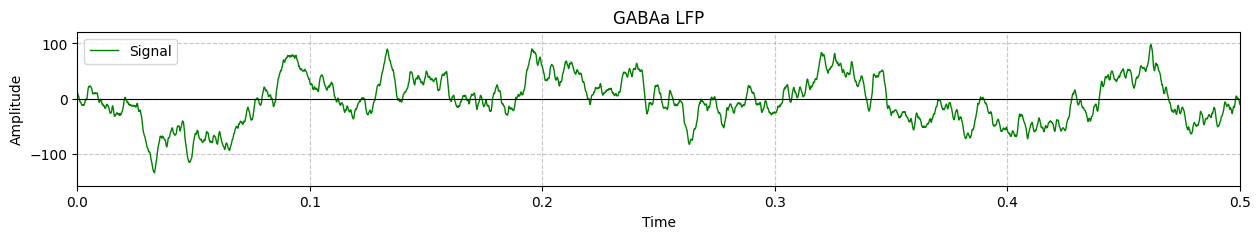

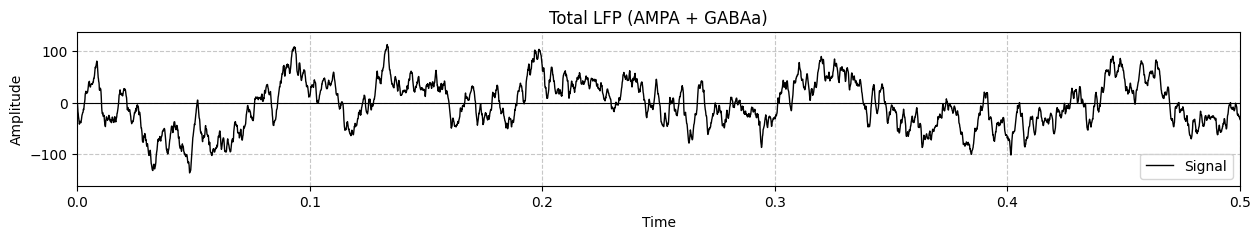

In [11]:
plot_trace(lfp_ex, time_lfp, title = 'AMPA LFP', size = (15, 2), xlim = (0, 0.5), trace_color = 'b', linewidth = 1)
plot_trace(lfp_in, time_lfp, title = 'GABAa LFP', size = (15, 2), xlim = (0, 0.5), trace_color = 'g', linewidth = 1)
plot_trace(lfp_total, time_lfp, title = 'Total LFP (AMPA + GABAa)', size = (15, 2), xlim = (0, 0.5), trace_color = 'black', linewidth = 1)

---
##### **Describing signal dynamics**

In [12]:
def circular_autocorrelation(signal, fs):
    
    N = signal.shape[-1]
    time_lags = np.arange(N) / fs
    
    F_signal = np.fft.fft(signal)
    psd = F_signal * np.conj(F_signal)
    autocorr = np.fft.ifft(psd).real

    return autocorr / N, time_lags
    

def circular_crosscorrelation(signal1, signal2, fs):
    
    N = signal1.shape[-1]
    assert signal2.shape[-1] == N
    time_lags = np.arange(N) / fs
    
    F1 = np.fft.fft(signal1)
    F2 = np.fft.fft(signal2)
    cross_psd = F1 * np.conj(F2)
    cross_corr = np.fft.ifft(cross_psd).real
    
    return cross_corr / N, time_lags


def psi_pattern(signal, fs):
    
    # The frequency rate needs to be defined to compute a good estimate 
    # of the derivative of the autocorrelation
    
    N = signal.shape[-1]
    time_lags = np.arange(N) / fs
    
    autocorr, _ = circular_autocorrelation(signal, fs)
    psi = -np.gradient(autocorr, 1 / fs, axis = -1)
    
    return psi, time_lags 


def averaged_multitaper_psd(signal, fs, window_sec, overlap_sec, NW = 3):
    
    """
    Parameters:
    - signal: 1D array of the time-series data 
    - fs: Sampling frequency
    - window_sec: Length of each segment in seconds
    - overlap_sec: Overlap between segments in seconds
    - NW: Time-bandwidth product. 
    
    NW controls the smoothing of the PSD. A higher value implies a smoother trace but less frequency resolution. 
    
    """
    
    n_window = int(window_sec * fs)
    n_overlap = int(overlap_sec * fs)
    step = n_window - n_overlap
    
    # This creates a virtual view without copying data (memory efficient)
    # Shape: (number of windows, samples per window)
    windows = sliding_window_view(signal, window_shape = n_window)[::step].copy()
    
    # Compute multitaper PSD using nitime package
    freqs, psd_all, _ = multi_taper_psd(windows, Fs = fs, NW = NW, adaptive = True, jackknife = False)
    avg_psd = np.mean(psd_all, axis = 0)
    
    return avg_psd, freqs


def averaged_psi_pattern(signal, fs, window_sec, overlap_sec):
    
    # This function uses the same logic as the multitaper function to compute the 
    # averaged PSI pattern across all segments of a given signal
    
    n_window = int(window_sec * fs)
    n_overlap = int(overlap_sec * fs)
    step = n_window - n_overlap
    
    segments = sliding_window_view(signal, window_shape = n_window)[::step].copy()
    psi_segments, time_lags = psi_pattern(segments, fs)
    avg_psi = np.mean(psi_segments, axis = 0)
    
    return avg_psi, time_lags

In [13]:
def psi_params(psi, time_lags, decay_threshold = 0.15):
    
    idx_max = np.argmax(psi)
    max_val = psi[idx_max]
    t_max = time_lags[idx_max]
    rise_time = t_max - time_lags[0]
    
    psi_decay_seg = psi[idx_max: ]
    target_val = max_val * decay_threshold
    
    # The decay time index is relative to the segment (we have to add the initial part)
    below_target_indices = np.where(psi_decay_seg <= target_val)[0]
    idx_decay_relative = below_target_indices[0]
    idx_decay_end = idx_max + idx_decay_relative
    
    t_decay_end = time_lags[idx_decay_end]
    decay_time = t_decay_end - t_max
    
    return t_max, rise_time, decay_time, max_val


def specparam(psd, freqs, freq_range = [40, 85], aperiodic_mode = 'fixed', verbose = False):
    
    fm = SpectralModel(peak_width_limits=[1, 8], max_n_peaks=6, min_peak_height=0.15, aperiodic_mode = aperiodic_mode)
    fm.add_data(freqs, psd, freq_range)
    fm.fit()
    
    aperiodic_params = fm.results.params.aperiodic.params
    error = fm.results.metrics.results['error_mae']
    r2 = fm.results.metrics.results['gof_rsquared']
    
    if verbose == True:
        print(f'Aperiodic Params: {aperiodic_params}')
        print(f'Error: {error}')
        print(f'R2: {r2}')
    
    return fm

In [14]:
# Signal parameters 
t_sec = 300
fs = 10000
window_sec = 2
overlap_sec = 1

# Synaptic parameters
n_ex = 5000
n_in = 5000
rate_ex = 0
rate_in = 50
w_ex = -1
w_in = 1

kernel_ampa, time_ampa = dual_exponential(t_sec = t_sec, 
                                          fs = fs, 
                                          tau_rise_s = 0.2 / 1000,
                                          tau_decay_s = 2 / 1000, 
                                          max_amplitude = 1)

kernel_gaba, time_gaba = dual_exponential(t_sec = t_sec, 
                                          fs = fs, 
                                          tau_rise_s = 0.5 / 1000,
                                          tau_decay_s = 10 / 1000, 
                                          max_amplitude = 1)

lfp_total, lfp_ex, lfp_in, time_lfp = simulate_fpp_balance(kernel_ex = kernel_ampa, 
                                                           kernel_in = kernel_gaba, 
                                                           fs = fs, 
                                                           t_sec = t_sec, 
                                                           n_ex = n_ex, 
                                                           n_in = n_in, 
                                                           rate_ex = rate_ex, 
                                                           rate_in = rate_in,
                                                           w_ex = w_ex,
                                                           w_in = w_in)

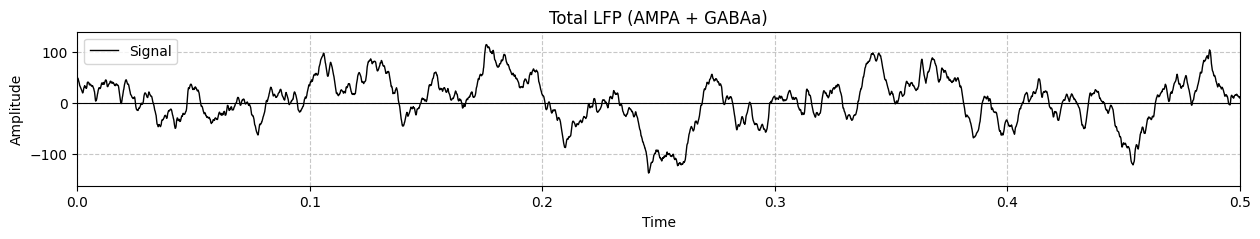

In [15]:
plot_trace(lfp_total, time_lfp, title = 'Total LFP (AMPA + GABAa)', size = (15, 2), xlim = (0, 0.5), trace_color = 'black', linewidth = 1)

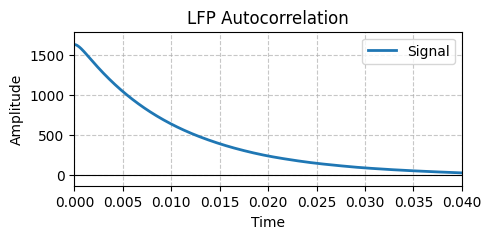

In [16]:
acf, time_acf = circular_autocorrelation(signal = lfp_total, fs = fs)
plot_trace(acf, time_acf, title = 'LFP Autocorrelation', xlim = (0, 0.04))

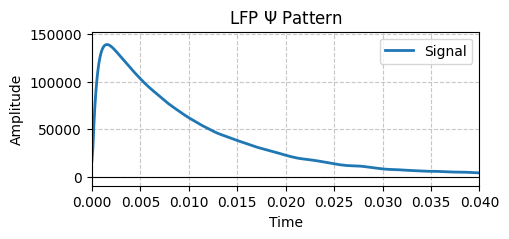

In [17]:
psi, time_psi = averaged_psi_pattern(signal = lfp_total, fs = fs, window_sec = window_sec, overlap_sec = overlap_sec)
plot_trace(psi, time_psi, title = 'LFP $\Psi$ Pattern', xlim = (0, 0.04))

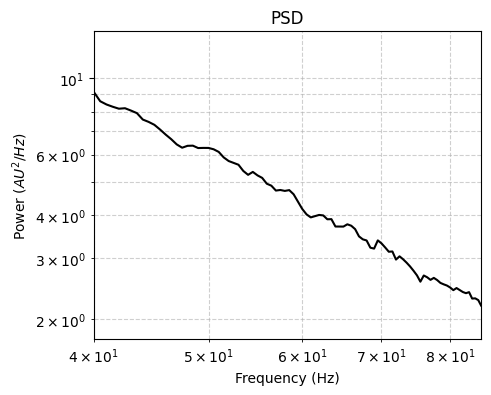

In [18]:
psd, freqs = averaged_multitaper_psd(signal = lfp_total, fs = fs, window_sec = window_sec, overlap_sec = overlap_sec, NW = 3)
plot_psd_log(psd = psd, freqs = freqs, xlim = (40, 85))

Aperiodic Params: [3.97305298 1.87952588]
Error: 0.00957350497296864
R2: 0.9954537049308999
                                                                                                  
                                       POWER SPECTRUM MODEL                                       
                                                                                                  
                       The model was fit with the 'spectral_fit' algorithm                        
              Model was fit to the 40-85 Hz frequency range with 0.50 Hz resolution               
                                                                                                  
                               Aperiodic Parameters ('fixed' mode)                                
                                        (offset, exponent)                                        
                                          3.9731, 1.8795                                          
                 

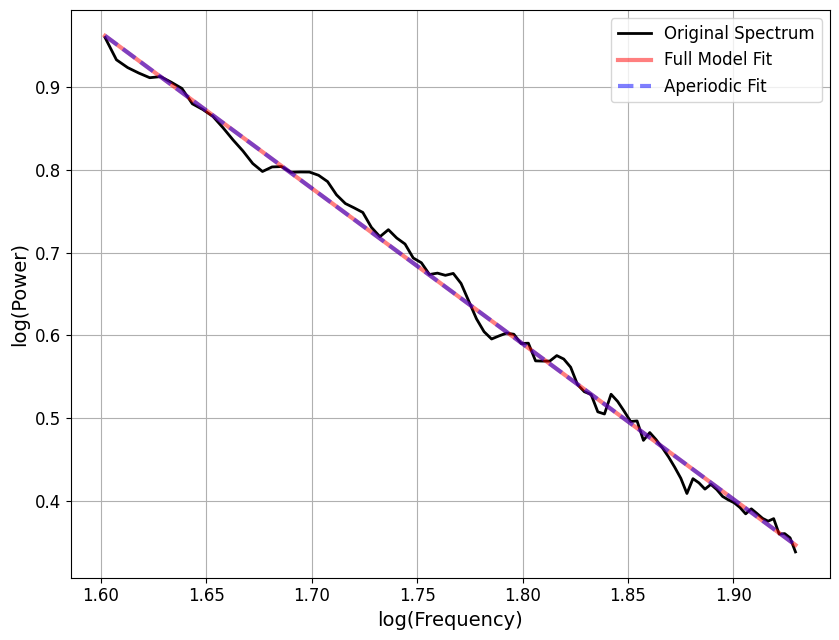

In [19]:
model = specparam(psd = psd, freqs = freqs, verbose = True)
model.report(freqs, psd, [40, 85], plt_log = True)

---
##### **Quantifying changes in excitatory-inhibitory balance (EIB)**
We will test three different ways to quantify the EIB:
- Duration of the pattern (time taken to descend to 15% percent of the maximum amplitude)
- Slope of the aperiodic component (linear regression between 40 and 85 Hz)
- Slope of the aperiodic component (double exponent fit between 1 and 300 Hz)


In [20]:
# Tenemos que crear una función que simule muchos LFP con distintos balances
# El balance se cambia alterando el número de neuronas excitatorias e inhibitorias
# Cuantificar los paramtros del patrón + PSD utilizando las dos modalidades de specparam
# Almacenar todos los datos en un dataframe y luego exportarlos en un .csv 
# Finalmente podríamos ver cual de los tres métodos es mejor para cuantificar el EIB (buscar algún test estadístico)

# HACER ESTO EN OTRO DOCUMENTO UTILIZANDO LAS DISTINTAS UTILS